<a href="https://colab.research.google.com/github/obov/mnist/blob/main/1_3_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST 실습

이번에는 28x28 흑백 손글씨 이미지를 보고 0~9 사이의 숫자 중 어떤 숫자를 쓴 것인지 예측하는 문제를 실습합니다.
이번 실습에서는 GPU를 활용할 것이기 때문에, 이전 챕터에서 Colab에서 GPU를 설정하는 방법을 따라해주시길 바랍니다.

GPU를 설정했으면 library들을 import합니다.

In [16]:
import torch
import torchvision
import torchvision.transforms as transforms

다음은 dataset을 준비합니다. 손글씨 dataset은 MNIST라는 유명한 dataset이 있습니다. 이 dataset은 `torchvision`에서 제공하고 있으며, 다음과 같이 다운로드 받을 수 있습니다.

In [17]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



MNIST는 손글씨 사진과 어떤 숫자를 의미하는지에 대한 label의 pair들로 구성되어있습니다.
이 때, 우리는 PyTorch model을 사용할 것이기 때문에 손글씨 사진들을 모두 tensor로 변환해야합니다.
이러한 부가적인 변환들은 `torchvision.transforms`에서 제공하고 있으며, `torchvision.datasets.MNIST`에서 `transform` 인자로 받을 수 있습니다.
우리는 단순히 사진을 tensor로 바꾸고 싶기 때문에 `transforms.ToTensor()` transformation을 넘겨줍니다.

다음은 전체 data의 개수와 첫 번째 data를 출력한 결과입니다.

60000
torch.Size([1, 28, 28]) 5


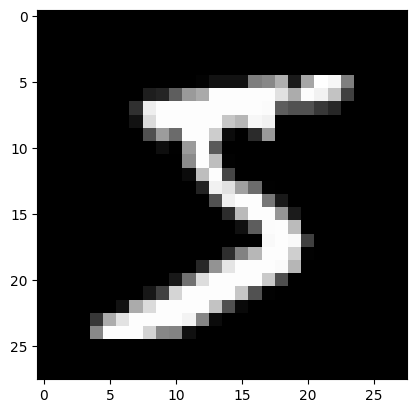

In [18]:
from matplotlib import pyplot as plt


print(len(trainset))
print(trainset[0][0].shape, trainset[0][1])
plt.imshow(trainset[0][0][0], cmap='gray')

첫 번째 출력결과를 통해 우리는 6만장의 손글씨 data가 있는 것을 알 수 있습니다.
그리고 두 번째 출력결과를 통해 첫 번째 data의 shape은 (1, 28, 28)이고 5라는 숫자를 쓴 사진이라는 것을 알 수 있습니다.
마지막으로 `plt.imshow`를 통해 visualize 했을 때 5라는 숫자가 나오는 것을 알 수 있습니다.

다음은 SGD를 위해 dataset을 여러 개의 batch로 나누는 과정을 PyTorch로 구현한 모습입니다.

In [19]:
from torch.utils.data import Subset


batch_size = 64
# 0부터 47999까지는 훈련용, 48000부터 59999까지는 검증용으로 설정
train_indices = list(range(48000))
val_indices = list(range(48000, 60000))

train_dataset = Subset(trainset, train_indices)
val_dataset = Subset(trainset, val_indices)

train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=batch_size,
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size, 
    shuffle=False
)

PyTorch에서는 `DataLoader`가 dataset을 인자로 받아 batch로 나눠줍니다.
부가적으로 `batch_size`라는 인자를 통해 batch size를 받고 있으며, `shuffle`이라는 인자를 통해 data들을 섞을지 결정해줍니다.
우리는 SGD가 완전 랜덤으로 batch를 구성해야 잘 동작하는 것을 알고 있기 때문에 `shuffle`에 `True`를 넘겨주고 있습니다.

다음은 첫 번째 batch를 출력한 모습입니다.

In [20]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


`images`는 첫 번째 batch의 image들이고 `labels`는 첫 번째 batch의 label들입니다.
위에서 batch size를 64로 설정했기 때문에 총 64개의 image와 label들이 있어야 합니다.
실제 shape 출력 결과를 보면 그렇다는 것을 알 수 있습니다.

다음은 (n, 1, 28, 28) shape의 image를 입력받아 0~9 사이의 정수 하나를 출력하는 3-layer MLP를 구현합니다.

In [21]:
from torch import nn

output_dim = 10

class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, output_dim)

    self.act = nn.ReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.layer3(x) # 마지막 레이어에서는 활성화 함수 필요 없음

    return x


model = Model(28 * 28 * 1, 1024)

이전의 2-layer MLP와 유사한 형태임을 알 수 있습니다.
여기서 특이사항은 `forward`의 첫 번째 줄에 `torch.flatten`을 사용한다는 것입니다.
`Linear`는 이전에도 봤다시피 (n, d) 형태의 shape을 입력받습니다.
이미지는 (n, 1, 28, 28)이기 때문에 (n, 1 * 28 * 28)로 shape을 변환해야 선형 함수에 입력으로 주어줄 수 있게 됩니다.
이 역할을 수행하는 것이 바로 `torch.flatten`입니다.
우리는 첫 번째 shape인 n을 보존할 것이기 때문에 flatten할 차원은 `start_dim=1`로 넘겨주게 됩니다.

다음은 gradient descent를 수행해줄 optimizer를 구현하는 모습입니다.

In [22]:
from torch.optim import SGD

if torch.backends.mps.is_available():
    device = torch.device("mps")
    model = model.to(device)
else:
    device = torch.device("cpu")
    model = model.to(device)
    print("MPS를 사용할 수 없습니다. CPU로 실행됩니다.")

lr = 0.001

optimizer = SGD(model.parameters(), lr=lr)

이전 코드와 거의 똑같습니다. 다른 점은 `model.to('cuda')` 코드를 통해 우리가 구현한 model을 GPU로 옮긴 것입니다.
MNIST 부터는 모델과 data가 커지면서 훨씬 많은 행렬 연산이 이루어지기 때문에 GPU를 활용하는 것이 빠릅니다.

다음은 model을 MNIST에 학습하는 코드입니다.

In [23]:
n_epochs = 100

CEL = nn.CrossEntropyLoss()

for epoch in range(n_epochs):
    model.train()  # 훈련 모드로 전환
    total_loss = 0.
    
    # 훈련 루프
    for data in train_loader:
        model.zero_grad()
        inputs, labels = data
        inputs, labels = inputs.to('mps'), labels.to('mps')

        preds = model(inputs)
        # loss = (preds[:, 0] - labels).pow(2).mean()
        # 손실 계산
        loss = CEL(preds, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch:3d} | Training Loss: {total_loss:.4f}")
    
    # 검증 루프
    model.eval()  # 검증 모드로 전환
    val_loss = 0.
    with torch.no_grad():  # 검증할 때는 no_grad()를 사용하여 파라미터 업데이트를 하지 않음
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to('mps'), labels.to('mps')

            preds = model(inputs)
            # loss = (preds[:, 0] - labels).pow(2).mean()
            # 손실 계산
            loss = CEL(preds, labels)

            val_loss += loss.item()
    print(f"Epoch {epoch:3d} | Validation Loss: {val_loss:.4f}")

Epoch   0 | Training Loss: 1711.5603
Epoch   0 | Validation Loss: 423.9959
Epoch   1 | Training Loss: 1669.7671
Epoch   1 | Validation Loss: 411.8422
Epoch   2 | Training Loss: 1612.1990
Epoch   2 | Validation Loss: 393.9694
Epoch   3 | Training Loss: 1524.4385
Epoch   3 | Validation Loss: 366.3619
Epoch   4 | Training Loss: 1390.9920
Epoch   4 | Validation Loss: 325.7697
Epoch   5 | Training Loss: 1209.4975
Epoch   5 | Validation Loss: 275.1008
Epoch   6 | Training Loss: 1009.8147
Epoch   6 | Validation Loss: 225.7611
Epoch   7 | Training Loss: 836.7014
Epoch   7 | Validation Loss: 186.8352
Epoch   8 | Training Loss: 707.7516
Epoch   8 | Validation Loss: 158.9955
Epoch   9 | Training Loss: 615.5517
Epoch   9 | Validation Loss: 139.1497
Epoch  10 | Training Loss: 548.8388
Epoch  10 | Validation Loss: 124.5575
Epoch  11 | Training Loss: 498.8522
Epoch  11 | Validation Loss: 113.5674
Epoch  12 | Training Loss: 460.5467
Epoch  12 | Validation Loss: 105.1149
Epoch  13 | Training Loss: 430.

출력 결과를 보면 잘 수렴하는 것을 볼 수 있습니다.
이전 구현과 다른 점은 다음 두 가지입니다.
- `for data in trainloader`를 통해 batch들을 iterate하면서 model을 학습합니다.
- `inputs, labels = inputs.to('cuda'), labels.to('cuda')`를 통해 model의 입력으로 들어가는 tensor들을 GPU로 보냅니다.

마지막으로 첫 번째 data에 대한 예측 결과를 살펴봅시다.

In [24]:
idx = 0

x = trainset[idx][0][None]  # (1, 1, 28, 28)
x = x.to('mps')

print(model(x))
print(trainset[idx][1])

tensor([[ 0.8052, -3.1639,  1.5161,  5.5696, -7.6434,  7.6127, -3.8879,  0.4515,
         -0.4014, -0.4364]], device='mps:0', grad_fn=<LinearBackward0>)
5


여기서 idx를 조정하여 다른 data에 대한 출력 결과도 볼 수 있습니다.
예측 결과를 보시면 아직 성능이 그렇게 좋지 않은 것을 알 수 있습니다.

In [25]:
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt